# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

     |████████████████████████████████| 88 kB 3.3 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 376 kB 29.1 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=9eda34bc4717c129344fe6220d334b13bf798da9db33814c90b03ecc49b0f4c8
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=62388f21403d57a1ac7cffc11516a69f310fd794501b48b433148a1299def02e
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-_3hfq1ja
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-_3hfq1ja
   

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 13.84 MiB/s, done.
Resolving deltas: 100% (3/3), done.


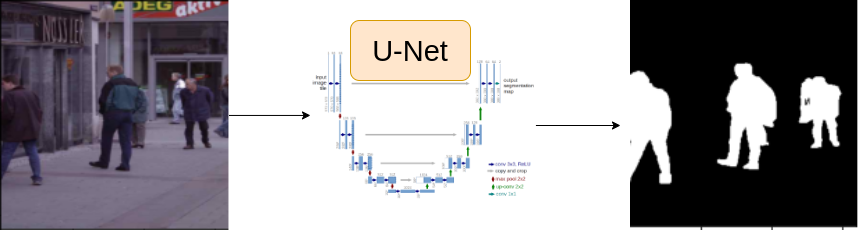

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = 'content'

DEVICE = 'cuda' #because we are using GPU
EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0


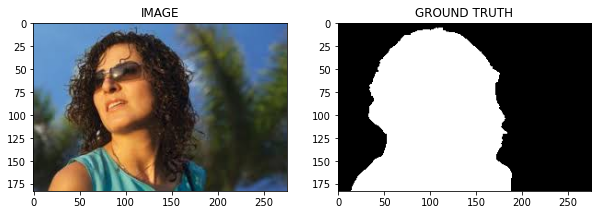

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
                    A.Resize(IMG_SIZE, IMG_SIZE),
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5)
                    ])
def get_valid_augs():
    return A.Compose([A.Resize(IMG_SIZE,IMG_SIZE)])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    image_path = row.images
    mask_path =row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w,c)
    mask = np.expand_dims(mask, axis=-1)

    if self.augmentations:
      data = self.augmentations(image = image, mask = mask)
      image = data['image']
      mask = data['mask']

      #(h, w, c) -> (c, h, w)

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image) / 255.0
      mask = torch.round(torch.Tensor(mask) / 255.0)

      return image, mask


In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


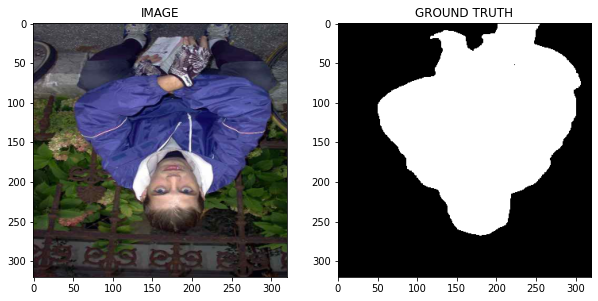

In [ ]:
idx = 25

image, mask = trainset[idx]
helper.show_image(image, mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"total no. of batches in trainloader : {len(trainloader)}")
print(f"total no. of batches in validloader : {len(validloader)}")

total no. of batches in trainloader : 15
total no. of batches in validloader : 4


In [ ]:
for image, mask in trainloader:
  break

print(f"One batch image shape : {image.shape}")
print(f"One batch mask shape : {mask.shape}")

One batch image shape : torch.Size([16, 3, 320, 320])
One batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel (nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):
    logits = self.arc(images)
    if mask != None:
      loss1 = DiceLoss(mode ='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2

    return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss = 0.0

  for images, masks in tqdm(data_loader):

    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):

      images = images.to(DEVICE)
      masks = masks.to(DEVICE)


      logits, loss = model(images, masks)

      total_loss += loss.item()

  return total_loss / len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Saved Model")
    best_valid_loss = valid_loss

  print(f"Epoch : {i+1} Train_loss : {train_loss} Valid_loss : {valid_loss}")

100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Saved Model
Epoch : 1 Train_loss : 0.7757723689079284 Valid_loss : 2.628378391265869


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]


Saved Model
Epoch : 2 Train_loss : 0.37813241879145304 Valid_loss : 0.3792021870613098


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Saved Model
Epoch : 3 Train_loss : 0.2704958111047745 Valid_loss : 0.2866622507572174


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch : 4 Train_loss : 0.24663000305493674 Valid_loss : 0.3097691386938095


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch : 5 Train_loss : 0.2667014280954997 Valid_loss : 0.447037260979414


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch : 6 Train_loss : 0.26669142047564187 Valid_loss : 0.40885454416275024


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Saved Model
Epoch : 7 Train_loss : 0.21679687201976777 Valid_loss : 0.26971668004989624


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Saved Model
Epoch : 8 Train_loss : 0.1947016288836797 Valid_loss : 0.20100118964910507


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Saved Model
Epoch : 9 Train_loss : 0.15987146993478138 Valid_loss : 0.1889292187988758


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Saved Model
Epoch : 10 Train_loss : 0.15227577636639278 Valid_loss : 0.18024956807494164


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Saved Model
Epoch : 11 Train_loss : 0.1429780085881551 Valid_loss : 0.17751406878232956


100%|██████████| 4/4 [00:01<00:00,  2.73it/s]


Epoch : 12 Train_loss : 0.1471694032351176 Valid_loss : 0.2557922601699829


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 13 Train_loss : 0.16097244024276733 Valid_loss : 0.26548684388399124


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 14 Train_loss : 0.15683976113796233 Valid_loss : 0.2612856701016426


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch : 15 Train_loss : 0.16523215671380362 Valid_loss : 0.21541478484869003


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Epoch : 16 Train_loss : 0.1464625135064125 Valid_loss : 0.20989995077252388


100%|██████████| 4/4 [00:01<00:00,  2.70it/s]


Epoch : 17 Train_loss : 0.1296903813878695 Valid_loss : 0.20970934629440308


100%|██████████| 4/4 [00:01<00:00,  2.76it/s]


Epoch : 18 Train_loss : 0.16193032413721084 Valid_loss : 0.30951521173119545


100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


Epoch : 19 Train_loss : 0.12815212259689968 Valid_loss : 0.18853365257382393


100%|██████████| 4/4 [00:01<00:00,  2.74it/s]


Saved Model
Epoch : 20 Train_loss : 0.12863991955916088 Valid_loss : 0.16648127883672714


100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


Epoch : 21 Train_loss : 0.11397609859704971 Valid_loss : 0.1799541711807251


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Saved Model
Epoch : 22 Train_loss : 0.11316793660322826 Valid_loss : 0.14060591533780098


100%|██████████| 4/4 [00:01<00:00,  2.75it/s]


Epoch : 23 Train_loss : 0.1147382045785586 Valid_loss : 0.15975650399923325


100%|██████████| 4/4 [00:01<00:00,  2.72it/s]


Epoch : 24 Train_loss : 0.10728545437256495 Valid_loss : 0.16787288337945938


100%|██████████| 4/4 [00:01<00:00,  2.77it/s]

Epoch : 25 Train_loss : 0.104404845337073 Valid_loss : 0.17383968830108643


# Task 9 : Inference

In [ ]:
idx = 20

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))  #(C,H, W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

AttributeError: ignored

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))